This file runs and generates results and figures for downstream tasks trained on ResNet152-generated features

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import io as b_io
import os
from pathlib import Path
import dill
from mosaiks import config as c
from mosaiks import transforms
from mosaiks.utils.imports import *
from threadpoolctl import threadpool_limits

env variable MOSAIKS_HOME not defined; setting to: "/home/ubuntu/cs230/mosaiks-paper"
If not desired, please reset os.environ["MOSAIKS_NAME"]


In [2]:
# we use ridge regression for all comparisons
solver = solve.ridge_regression

This cell loads the embeddings generated by the ResNet152

In [6]:
X = {}
latlons = {}

samples = [];
# samples.append("UAR")
samples.append("POP")

for sample in samples:
    features_path = (
        Path(c.features_dir)
        / f"{c.features['pretrained']['model_type']}_pretrained_{c.grid['area']}_{c.images['zoom_level']}_{c.images['n_pixels']}_{sample}_backup.pkl"
    )
    with open(features_path, "rb") as f:
        data = np.load(f, allow_pickle=True)
    features = data["X"]
    latlons_samp = data["latlon"]
    ids_x = data["ids_X"]

    X[sample] = pd.DataFrame(features, index=ids_x)
    latlons[sample] = pd.DataFrame(latlons_samp, index=ids_x, columns=["lat", "lon"])

latlons[sample]
display(X[sample])
print(data["latlon"][:10])

/home/ubuntu/cs230/mosaiks-paper/data/int/feature_matrices/resnet152_pretrained_CONTUS_16_640_POP_backup.pkl
100000
<class 'numpy.ndarray'>
100000


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
"342,2056",1.742379,0.614696,0.346319,0.396723,1.381741,0.833970,0.576844,0.311210,0.763548,1.573764,...,0.489110,1.285998,0.838515,0.032531,0.567805,0.142141,1.260862,0.755522,0.199743,0.606539
"1616,2768",0.823037,1.338874,0.403724,0.176993,0.036064,0.067304,0.581723,0.482554,0.055277,0.243646,...,0.366134,0.299137,0.467878,0.384593,0.767442,0.758389,0.591593,0.148082,0.510817,0.077369
"1009,3643",0.690863,0.460124,0.662975,0.274924,0.065723,0.139468,0.269234,0.767279,0.158111,0.123426,...,0.373742,0.486923,0.219195,0.025234,0.158886,0.319875,0.139310,0.475110,0.379195,0.252499
"1856,2551",0.410384,1.025916,0.377073,0.192982,0.411847,0.839877,0.611888,0.512546,0.383540,0.349759,...,0.382156,0.563211,0.362694,0.034047,0.433420,0.229017,0.700132,0.131173,0.409678,0.091680
"859,3766",1.609615,0.210026,0.623834,0.487212,0.383056,0.694697,0.594685,0.059571,0.543780,0.369686,...,0.107465,2.090636,0.637467,0.319850,1.218611,0.317290,0.525214,0.569964,0.121869,0.447823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1950,2167",0.085664,0.410012,0.958855,0.209341,0.101762,0.583703,0.901701,0.328163,0.342352,0.362551,...,0.474883,0.340248,0.225320,0.613724,0.124896,0.597445,0.626682,1.024713,0.207635,0.423027
"897,3153",0.410328,0.095573,0.697796,0.200103,0.474857,0.225061,0.465141,0.161907,1.094199,0.134647,...,0.526134,0.774152,0.799660,0.463964,0.161272,1.331928,1.354502,0.494608,0.200620,0.397384
"2257,1998",0.242243,0.594426,1.110094,0.015670,0.596082,0.408577,0.661651,0.313935,0.040209,0.249360,...,0.380713,0.360395,0.518954,0.283955,0.179892,0.321911,0.309372,0.509611,0.200167,0.290693
"304,214",2.189235,0.820737,0.299856,0.175638,0.418665,0.260252,1.704176,0.504614,0.519670,0.579416,...,0.482961,1.282179,0.631663,0.532730,0.692484,0.143874,0.335746,0.229701,0.282071,0.522671


[[  46.88621912  -96.69764088]
 [  33.5643403   -86.89166536]
 [  40.24083507  -74.84078252]
 [  30.76696757  -89.8802843 ]
 [  41.7992458   -73.14677271]
 [  28.79491537  -82.52580266]
 [  39.58594664 -104.82337902]
 [  40.75397021  -73.8767119 ]
 [  30.19729845  -81.36891791]
 [  37.75831595  -92.09764675]]


Edit this to change what downstream task to run

In [7]:
labels_to_run = ["nightlights"]

In [8]:
# This code is based off of the ridge regression from the MOSAIKS codebase.

label = labels_to_run[0]

print("*** Running regressions for: {}".format(label))

## Set some label-specific variables
this_cfg = io.get_filepaths(c, label)
c_app = getattr(this_cfg, label)
outcome_name = c_app["variable"]
sampling_type = c_app["sampling"]  # UAR or POP

best_lambda_fpath = join(c.fig_dir_sec, "best_lambda_tl.npz")
if fixed_lambda:
    lambdas = io.get_lambdas(c, label, best_lambda_fpath=best_lambda_fpath)
else:
    lambdas = io.get_lambdas(c, label, best_lambda_fpath=None)

if c_app["logged"]:
    bounds = np.array([c_app["us_bounds_log_pred"]])
else:
    bounds = np.array([c_app["us_bounds_pred"]])

# Set solver arguments
solver_kwargs = {
    "lambdas": lambdas,
    "return_preds": True,
    "svd_solve": False,
    "clip_bounds": bounds,
}

# Expand possible lambdas for this transfer learning feature set as needed so that
# the optimal lambda selected is not hitting the bounds of possible lambdas.
if (not fixed_lambda) and (label in ["income", "roads"]):
    solver_kwargs["lambdas"] = np.logspace(-3, 4, 9)

## get X, Y, latlon values of training data
(
    this_X,
    this_X_test,
    this_Y,
    this_Y_test,
    _,
    _,
) = parse.merge_dropna_transform_split_train_test(
    this_cfg, label, X[sampling_type], latlons[sampling_type]
)

## subset
this_X = this_X[subset_n, subset_feat]
this_X_test = this_X_test[:, subset_feat]
this_Y = this_Y[subset_n]

## Train model using ridge regression and 5-fold cross-valiation
## (number of folds can be adjusted using the argument n_folds)
print("Training model...")
kfold_results = solve.kfold_solve(
    this_X,
    this_Y,
    solve_function=solver,
    num_folds=this_cfg.ml_model["n_folds"],
    return_model=True,
    **solver_kwargs
)
print("")

## Store the metrics from the best performing model
best_lambda_idx, _, _ = ir.interpret_kfold_results(
    kfold_results, "r2_score", hps=[("lambdas", solver_kwargs["lambdas"])]
)
best_lambdas = np.array(
    [solver_kwargs["lambdas"][np.asarray(best_lambda_idx).squeeze()]]
)

## Retrain a model using this best lambda:
holdout_results = solve.single_solve(
    this_X,
    this_X_test,
    this_Y,
    this_Y_test,
    lambdas=best_lambdas,
    return_preds=True,
    return_model=False,
    clip_bounds=bounds,
    svd_solve=False,
)

*** Running regressions for: nightlights
Loading labels...
Merging labels and features...
WHAT
[[0.12219389 0.885396   0.66125333 ... 0.98920155 0.21087767 0.31872317]
 [1.0613163  0.2993261  0.6927124  ... 0.7019906  0.36948434 1.9296793 ]
 [0.58927405 0.43096823 0.3229952  ... 0.49162048 0.6246209  1.8996377 ]]
Splitting training/test...
Training model...
on fold (of 5): 1 2 3 4 5 


Plot results

Plotting log_nightlights...


/home/ubuntu/anaconda3/envs/mosaiks-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubuntu/anaconda3/envs/mosaiks-env/lib/python3.9/site-packages/seaborn/axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


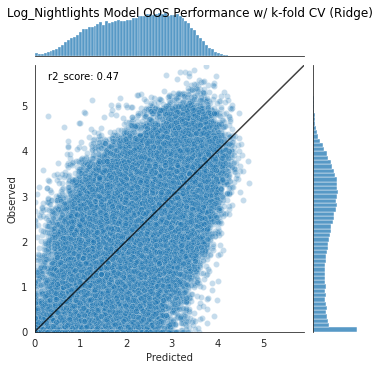

In [9]:
plots.performance_density(
    kfold_results,
    "Ridge",
    val=outcome_name,
    save_dir=None,
    app_name=label,
    kind="scatter",
    size=5
)